In [66]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import chi2, mutual_info_classif

In [38]:
# Load the data
data = pd.read_excel('./data/data_extended.xlsx')

# Display the first few rows of the data
print(data.head())

         SourceType                                  SourceDescription  \
0          Database                      Contains customer information   
1     System/Server                      Stores web server access logs   
2   Web Application                           Online shopping platform   
3            Device                        Records employee work hours   
4  Software/Program  Allows users to access bank accounts on mobile...   

            TargetName        TargetType  \
0           CRM System     System/Server   
1        SIEM Platform  Software/Program   
2      Payment Gateway           Service   
3       Payroll System     System/Server   
4  Core Banking System     System/Server   

                                   TargetDescription            Relationship  \
0            Customer Relationship Management system               Data Sync   
1  Security Information and Event Management plat...         Log Aggregation   
2                       Handles payment transactio

In [39]:
for col in data.columns:
    print(col)

SourceType
SourceDescription
TargetName
TargetType
TargetDescription
Relationship
AuthRequired
Encryption
EncryptionType
DataFormat
Frequency
DataIntegrity
AccessType
AccessTarget
NetworkProtocol
CommunicationChannel
CredentialStorage
Interactor
Threat


In [40]:
data = data[["SourceType", "TargetType", "AuthRequired", "Encryption", "EncryptionType", "DataFormat", "Frequency", "DataIntegrity", "AccessType",
             "AccessTarget", "NetworkProtocol", "CommunicationChannel", "CredentialStorage", "Interactor", "Threat"]]

In [41]:
data = data.replace([None, ''], pd.NA)

# Now, count the number of empty cells per column
empty_counts = data.isna().sum()

# Print the counts
print("Number of empty rows per col: ")
print(empty_counts)

Number of empty rows per col: 
SourceType              0
TargetType              0
AuthRequired            0
Encryption              0
EncryptionType          0
DataFormat              0
Frequency               0
DataIntegrity           0
AccessType              0
AccessTarget            0
NetworkProtocol         0
CommunicationChannel    0
CredentialStorage       0
Interactor              0
Threat                  0
dtype: int64


In [42]:
class_counts = data['Threat'].value_counts()
class_counts

Threat
Cross-Site Scripting (XSS)              507
Phishing Attacks                        506
Man-in-the-Middle (MitM) Attack         468
API Security Breach                     462
Malware Attack                          457
Malvertising                            445
SQL Injection                           427
Spear Phishing Attacks                  422
Ransomware Attack                       412
No Threat                               401
Zero-day Exploit                        394
Cryptojacking                           369
Cross-Site Request Forgery (CSRF)       209
Remote Code Execution (RCE)             204
Drive-by Download Attacks               200
Credential Stuffing                     191
Directory Traversal                     183
Distributed Denial of Service (DDoS)    176
Side-Channel Attack                     171
Password Attack                         153
Denial of Service (DoS)                  78
Name: count, dtype: int64

In [43]:
# Remove classes with fewer than X instances
valid_classes = class_counts[class_counts > 20].index
data = data[data['Threat'].isin(valid_classes)]

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SourceType            6835 non-null   object
 1   TargetType            6835 non-null   object
 2   AuthRequired          6835 non-null   object
 3   Encryption            6835 non-null   object
 4   EncryptionType        6835 non-null   object
 5   DataFormat            6835 non-null   object
 6   Frequency             6835 non-null   object
 7   DataIntegrity         6835 non-null   object
 8   AccessType            6835 non-null   object
 9   AccessTarget          6835 non-null   object
 10  NetworkProtocol       6835 non-null   object
 11  CommunicationChannel  6835 non-null   object
 12  CredentialStorage     6835 non-null   object
 13  Interactor            6835 non-null   object
 14  Threat                6835 non-null   object
dtypes: object(15)
memory usage: 801.1+ KB


In [45]:
unique_values_count = data.nunique()

value_counts_per_column = {col: data[col].value_counts() for col in data.columns}

unique_values_count, value_counts_per_column


(SourceType               7
 TargetType               7
 AuthRequired             2
 Encryption               2
 EncryptionType           6
 DataFormat               8
 Frequency                5
 DataIntegrity            4
 AccessType               5
 AccessTarget             8
 NetworkProtocol          8
 CommunicationChannel     7
 CredentialStorage        7
 Interactor               7
 Threat                  21
 dtype: int64,
 {'SourceType': SourceType
  Web Application     1385
  Device              1282
  Database            1189
  Service              988
  System/Server        820
  Software/Program     773
  User                 398
  Name: count, dtype: int64,
  'TargetType': TargetType
  Service             2016
  Database            1161
  Web Application     1135
  System/Server       1113
  Software/Program     834
  Device               289
  User                 287
  Name: count, dtype: int64,
  'AuthRequired': AuthRequired
  Yes    5470
  No     1365
  Name: count, d

In [46]:
print(data.describe(include='all'))

             SourceType TargetType AuthRequired Encryption EncryptionType  \
count              6835       6835         6835       6835           6835   
unique                7          7            2          2              6   
top     Web Application    Service          Yes        Yes        TLS/SSL   
freq               1385       2016         5470       5462           1712   

       DataFormat  Frequency DataIntegrity AccessType AccessTarget  \
count        6835       6835          6835       6835         6835   
unique          8          5             4          5            8   
top          JSON  Real-Time          Hash      Write     Database   
freq         2689       3235          2197       2842         3111   

       NetworkProtocol CommunicationChannel CredentialStorage Interactor  \
count             6835                 6835              6835       6835   
unique               8                    7                 7          7   
top         HTTP/HTTPS             

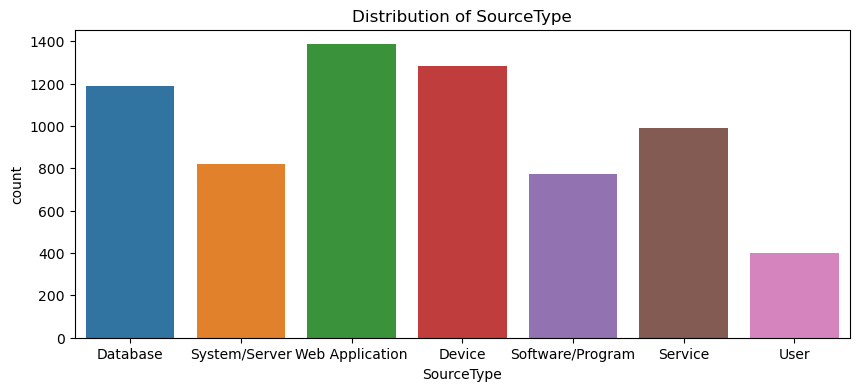

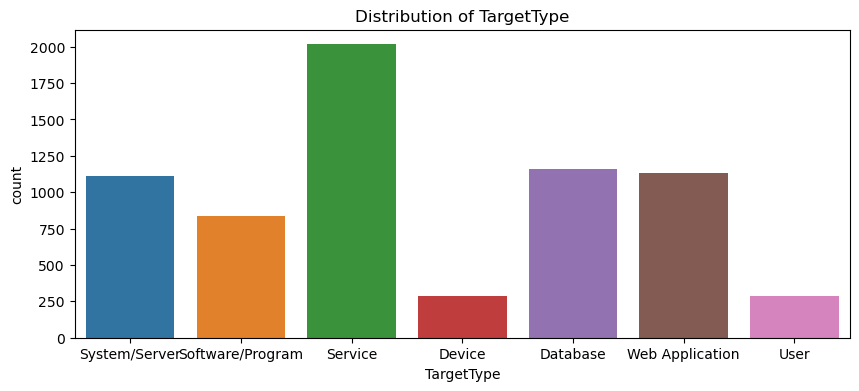

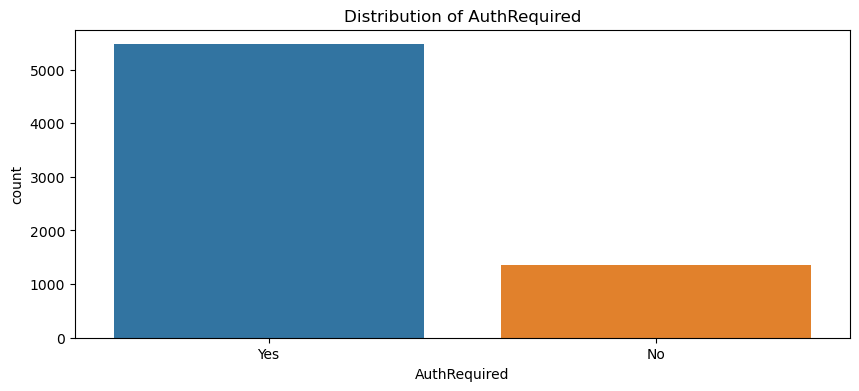

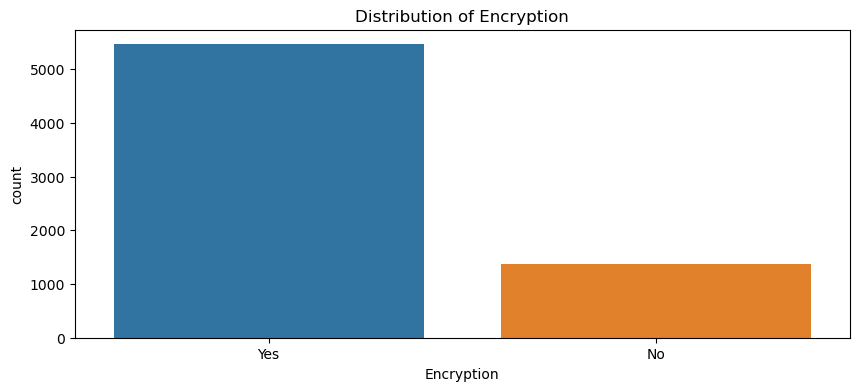

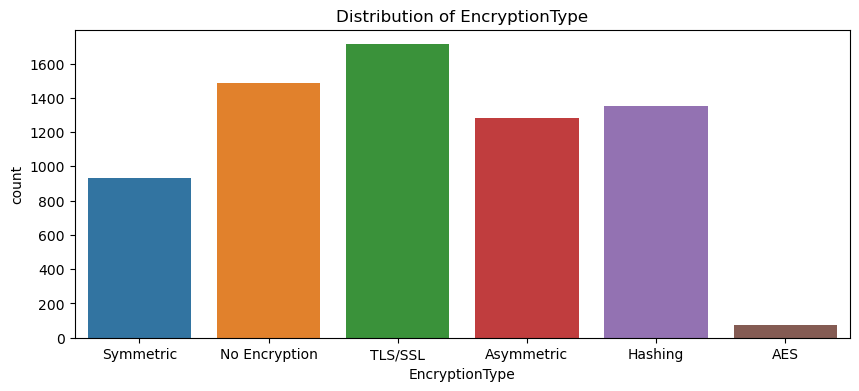

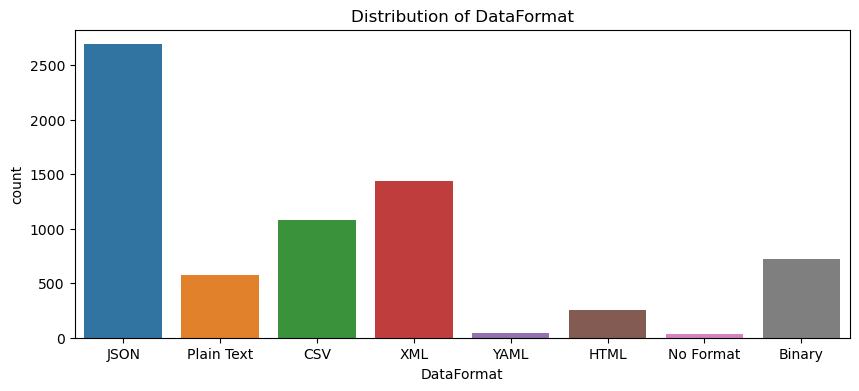

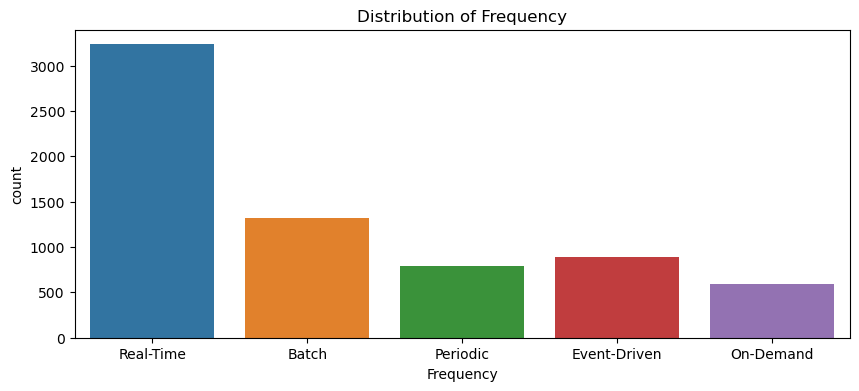

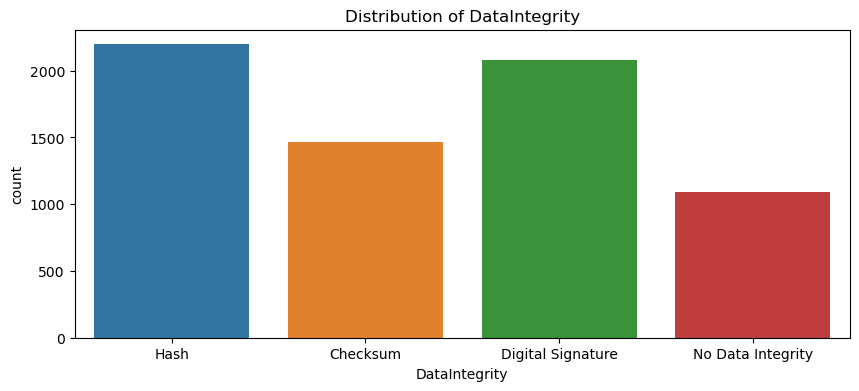

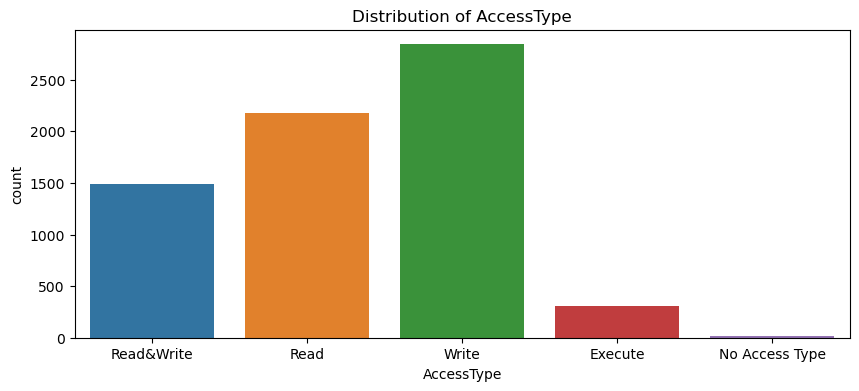

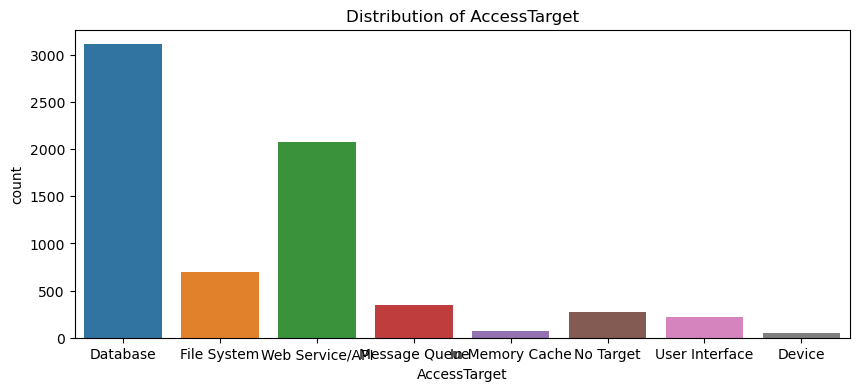

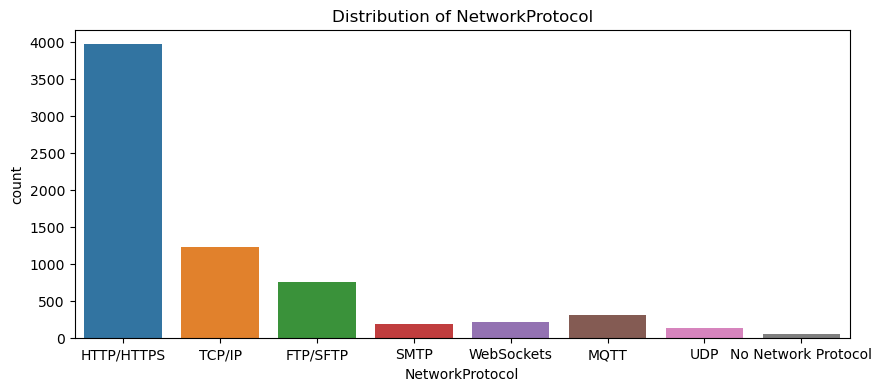

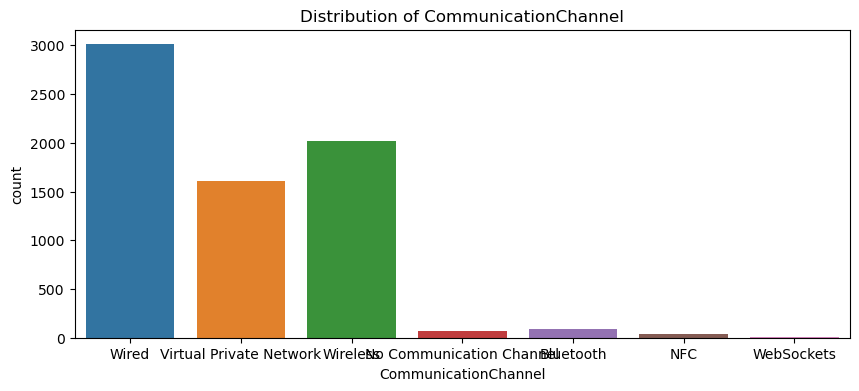

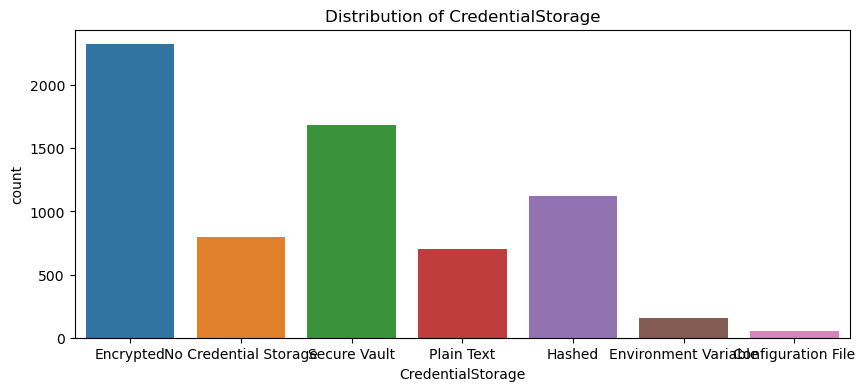

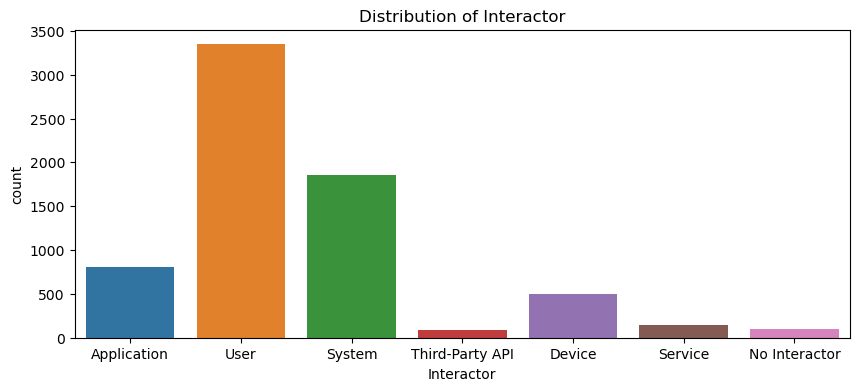

In [47]:
for column in data.drop('Threat', axis=1).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()


### Filtering data to only X threats with most occurencies

In [48]:
# Get the top X most occurring threats
top_X_threats = class_counts.nlargest(10).index

# Filter the original data to only include rows with these top X threats
filtered_data = data[data['Threat'].isin(top_X_threats)]

In [49]:
top_X_threats

Index(['Cross-Site Scripting (XSS)', 'Phishing Attacks',
       'Man-in-the-Middle (MitM) Attack', 'API Security Breach',
       'Malware Attack', 'Malvertising', 'SQL Injection',
       'Spear Phishing Attacks', 'Ransomware Attack', 'No Threat'],
      dtype='object', name='Threat')

### Reduction of Complexity (Experiment)

In [50]:
# Function to group values in a column
def group_values(column, mapping):
    return column.map(mapping).fillna(column)

# Define mappings for each column to reduce complexity
source_type_mapping = {
    'System/Server': 'System',
    'Device': 'Hardware',
    'Web Application': 'Software',
    'Software/Program': 'Software',
    'Database': 'Database',
    'Service': 'Service',
    'User': 'User'
}

target_type_mapping = {
    'System/Server': 'System',
    'Service': 'Service',
    'Database': 'Database',
    'Software/Program': 'Software',
    'Web Application': 'Software',
    'User': 'User',
    'Device': 'Hardware'
}

encryption_type_mapping = {
    'TLS/SSL': 'Encryption',
    'No Encryption': 'No Encryption',
    'Hashing': 'Encryption',
    'Asymmetric': 'Encryption',
    'Symmetric': 'Encryption',
    'AES': 'Encryption'
}

data_format_mapping = {
    'JSON': 'Structured',
    'XML': 'Structured',
    'CSV': 'Structured',
    'Binary': 'Binary',
    'Plain Text': 'Text',
    'HTML': 'Structured',
    'YAML': 'Structured',
    'No Format': 'No Format'
}

frequency_mapping = {
    'Real-Time': 'Frequent',
    'Batch': 'Infrequent',
    'Event-Driven': 'Frequent',
    'Periodic': 'Infrequent',
    'On-Demand': 'Infrequent'
}

data_integrity_mapping = {
    'Hash': 'Data Integrity',
    'Digital Signature': 'Data Integrity',
    'Checksum': 'Data Integrity',
    'No Data Integrity': 'No Data Integrity'
}

access_type_mapping = {
    'Write': 'Write',
    'Read': 'Read',
    'Read&Write': 'Read&Write',
    'Execute': 'Execute',
    'No Access Type': 'No Access'
}

access_target_mapping = {
    'Database': 'Data',
    'Web Service/API': 'Service',
    'File System': 'Data',
    'User Interface': 'User',
    'Message Queue': 'Service',
    'No Target': 'No Target',
    'In-Memory Cache': 'Data',
    'Device': 'Hardware'
}

network_protocol_mapping = {
    'HTTP/HTTPS': 'HTTP',
    'TCP/IP': 'TCP',
    'FTP/SFTP': 'FTP',
    'MQTT': 'Other',
    'WebSockets': 'Other',
    'SMTP': 'Other',
    'UDP': 'TCP',
    'No Network Protocol': 'None'
}

communication_channel_mapping = {
    'Wired': 'Wired',
    'Wireless': 'Wireless',
    'Virtual Private Network': 'VPN',
    'Bluetooth': 'Wireless',
    'No Communication Channel': 'None',
    'NFC': 'Wireless',
    'WebSockets': 'Other'
}

credential_storage_mapping = {
    'Encrypted': 'Secure',
    'Secure Vault': 'Secure',
    'No Credential Storage': 'None',
    'Hashed': 'Secure',
    'Plain Text': 'Insecure',
    'Environment Variable': 'Secure',
    'Configuration File': 'Secure'
}

interactor_mapping = {
    'User': 'Human',
    'System': 'System',
    'Application': 'System',
    'Device': 'Hardware',
    'Service': 'Service',
    'Third-Party API': 'External',
    'No Interactor': 'None'
}

# Apply the mappings to the dataframe
data_reduced = filtered_data.copy()
data_reduced['SourceType'] = group_values(data_reduced['SourceType'], source_type_mapping)
data_reduced['TargetType'] = group_values(data_reduced['TargetType'], target_type_mapping)
data_reduced['EncryptionType'] = group_values(data_reduced['EncryptionType'], encryption_type_mapping)
data_reduced['DataFormat'] = group_values(data_reduced['DataFormat'], data_format_mapping)
data_reduced['Frequency'] = group_values(data_reduced['Frequency'], frequency_mapping)
data_reduced['DataIntegrity'] = group_values(data_reduced['DataIntegrity'], data_integrity_mapping)
data_reduced['AccessType'] = group_values(data_reduced['AccessType'], access_type_mapping)
data_reduced['AccessTarget'] = group_values(data_reduced['AccessTarget'], access_target_mapping)
data_reduced['NetworkProtocol'] = group_values(data_reduced['NetworkProtocol'], network_protocol_mapping)
data_reduced['CommunicationChannel'] = group_values(data_reduced['CommunicationChannel'], communication_channel_mapping)
data_reduced['CredentialStorage'] = group_values(data_reduced['CredentialStorage'], credential_storage_mapping)
data_reduced['Interactor'] = group_values(data_reduced['Interactor'], interactor_mapping)

data_reduced.head()

,SourceType,TargetType,AuthRequired,Encryption,EncryptionType,DataFormat,Frequency,DataIntegrity,AccessType,AccessTarget,NetworkProtocol,CommunicationChannel,CredentialStorage,Interactor,Threat
0,Database,System,Yes,Yes,Encryption,Structured,Frequent,Data Integrity,Read&Write,Data,HTTP,Wired,Secure,System,SQL Injection
1,System,Software,No,No,No Encryption,Text,Infrequent,Data Integrity,Read,Data,TCP,VPN,None,System,Man-in-the-Middle (MitM) Attack
2,Software,Service,Yes,Yes,Encryption,Structured,Frequent,Data Integrity,Read&Write,Service,HTTP,Wired,Secure,Human,Phishing Attacks
4,Software,System,Yes,Yes,Encryption,Structured,Frequent,Data Integrity,Read&Write,Data,HTTP,Wireless,Secure,Human,Ransomware Attack
5,Database,System,Yes,Yes,Encryption,Structured,Frequent,Data Integrity,Read,Data,HTTP,Wired,Secure,System,SQL Injection


In [51]:
unique_values_count = data_reduced.nunique()

value_counts_per_column = {col: data_reduced[col].value_counts() for col in data_reduced.columns}

unique_values_count, value_counts_per_column


(SourceType               6
 TargetType               6
 AuthRequired             2
 Encryption               2
 EncryptionType           2
 DataFormat               4
 Frequency                2
 DataIntegrity            2
 AccessType               5
 AccessTarget             5
 NetworkProtocol          5
 CommunicationChannel     5
 CredentialStorage        3
 Interactor               6
 Threat                  10
 dtype: int64,
 {'SourceType': SourceType
  Software    1432
  Database     948
  Hardware     807
  Service      678
  System       442
  User         200
  Name: count, dtype: int64,
  'TargetType': TargetType
  Service     1424
  Software    1354
  Database     758
  System       605
  User         190
  Hardware     176
  Name: count, dtype: int64,
  'AuthRequired': AuthRequired
  Yes    3575
  No      932
  Name: count, dtype: int64,
  'Encryption': Encryption
  Yes    3622
  No      885
  Name: count, dtype: int64,
  'EncryptionType': EncryptionType
  Encryption      

In [52]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4507 entries, 0 to 6834
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SourceType            4507 non-null   object
 1   TargetType            4507 non-null   object
 2   AuthRequired          4507 non-null   object
 3   Encryption            4507 non-null   object
 4   EncryptionType        4507 non-null   object
 5   DataFormat            4507 non-null   object
 6   Frequency             4507 non-null   object
 7   DataIntegrity         4507 non-null   object
 8   AccessType            4507 non-null   object
 9   AccessTarget          4507 non-null   object
 10  NetworkProtocol       4507 non-null   object
 11  CommunicationChannel  4507 non-null   object
 12  CredentialStorage     4507 non-null   object
 13  Interactor            4507 non-null   object
 14  Threat                4507 non-null   object
dtypes: object(15)
memory usage: 563.4+ KB


# Data Encoding

In [53]:
# # Separate features and target variable
# X = filtered_data.drop('Threat', axis=1)
# y = filtered_data['Threat']

In [54]:
# # Separate features and target variable
# X = data.drop('Threat', axis=1)
# y = data['Threat']

In [55]:
# Separate features and target variable
X = data_reduced.drop('Threat', axis=1)
y = data_reduced['Threat']

In [56]:
# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert y_encoded to a DataFrame
y_encoded_df = pd.DataFrame(y_encoded, columns=['Encoded Target'])

# One-hot encode the categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder.fit_transform(X)

# Convert the encoded features to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(X.columns))

# Analysis of Data

### Correlation Analysis

In [25]:
# Define the number of top features to select
N = 25

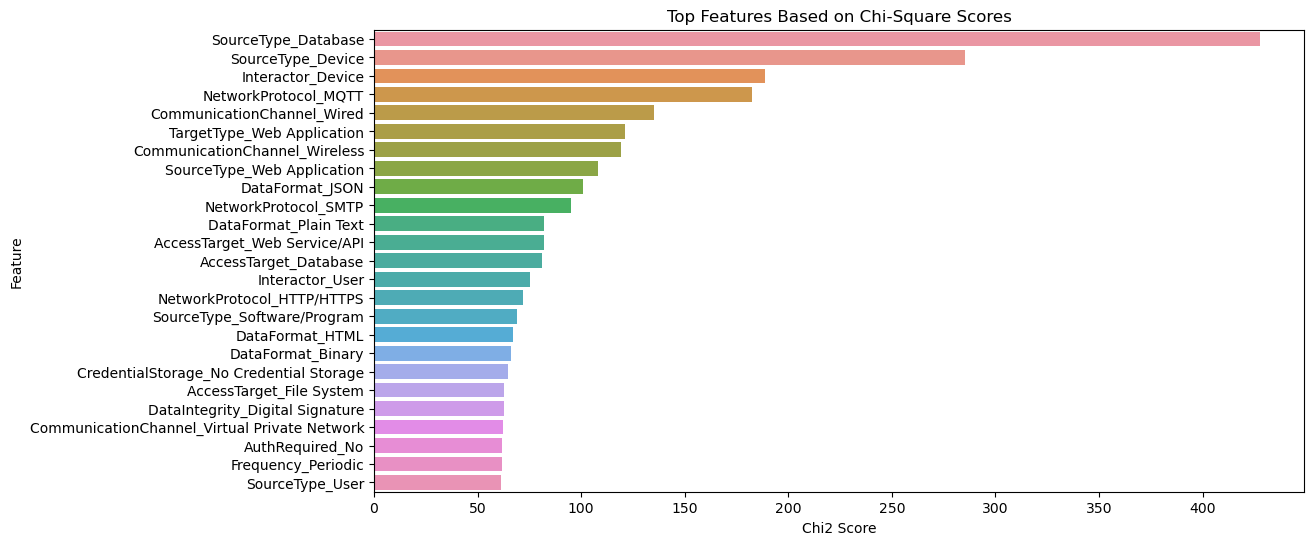

In [26]:
# Chi-Square Test
chi2_scores, p_values = chi2(X_encoded_df, y_encoded)
chi2_results = pd.DataFrame({'Feature': X_encoded_df.columns, 'Chi2 Score': chi2_scores, 'p-value': p_values})
chi2_resultsTOPN = chi2_results.sort_values(by='Chi2 Score', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_resultsTOPN)
plt.title('Top Features Based on Chi-Square Scores')
plt.show()

In [27]:
chi2_results

,Feature,Chi2 Score,p-value
0,SourceType_Database,427.628811,1.730624e-86
1,SourceType_Device,285.248649,3.497755e-56
2,SourceType_Service,38.006772,1.738266e-05
3,SourceType_Software/Program,69.042256,2.345687e-11
4,SourceType_System/Server,35.983904,3.990817e-05
...,...,...,...
78,Interactor_No Interactor,21.679660,9.951597e-03
79,Interactor_Service,10.091568,3.431233e-01
80,Interactor_System,41.679181,3.761344e-06
81,Interactor_Third-Party API,9.567767,3.865954e-01


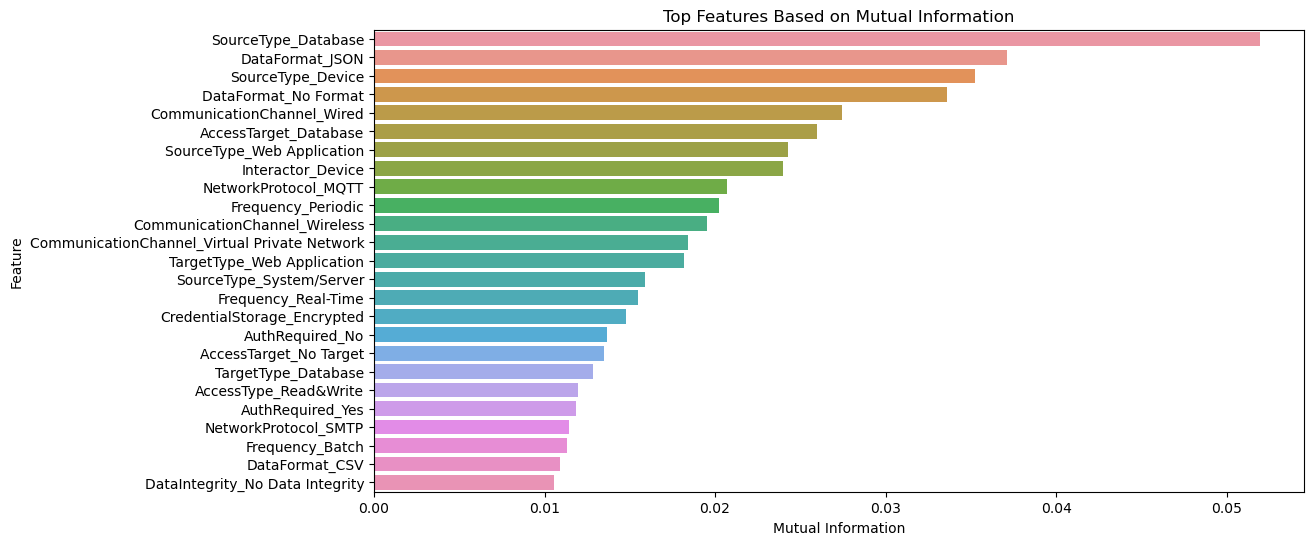

In [28]:
# Mutual Information
mutual_info = mutual_info_classif(X_encoded_df, y_encoded)
mutual_info_df = pd.DataFrame({'Feature': X_encoded_df.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mutual_info_df)
plt.title('Top Features Based on Mutual Information')
plt.show()

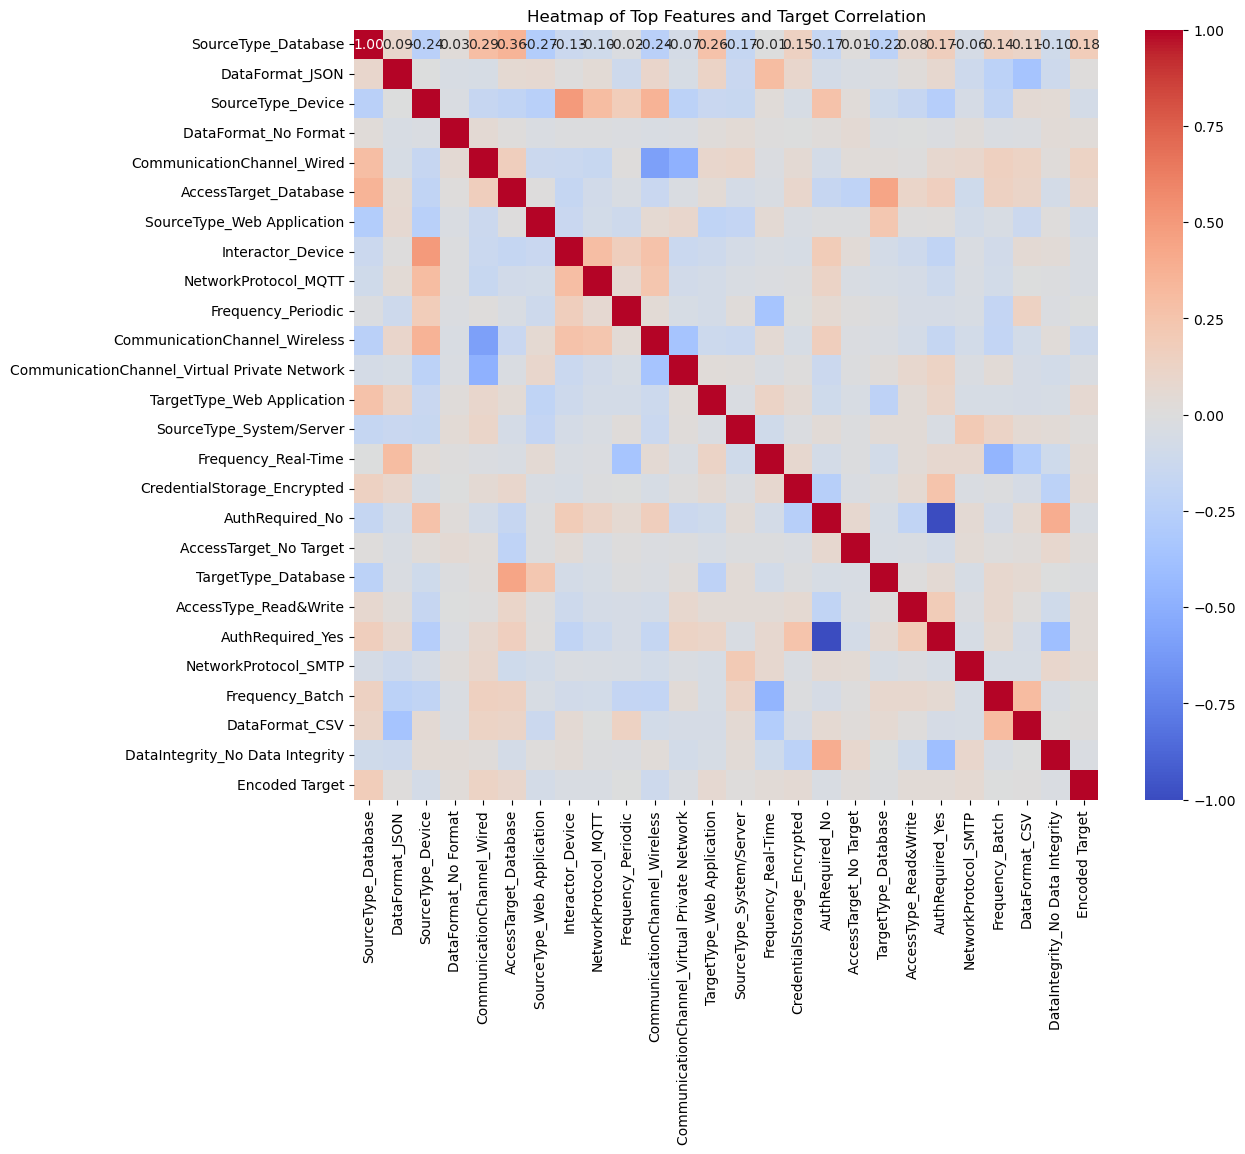

In [29]:
# Select top features based on mutual information (you can choose chi2 if preferred)
top_features = mutual_info_df['Feature']

# Create a heatmap only for the top features
top_features_df = X_encoded_df[top_features]

# Add the target variable for correlation calculation
heatmap_data = top_features_df.join(y_encoded_df)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Top Features and Target Correlation')
plt.show()

<Axes: >

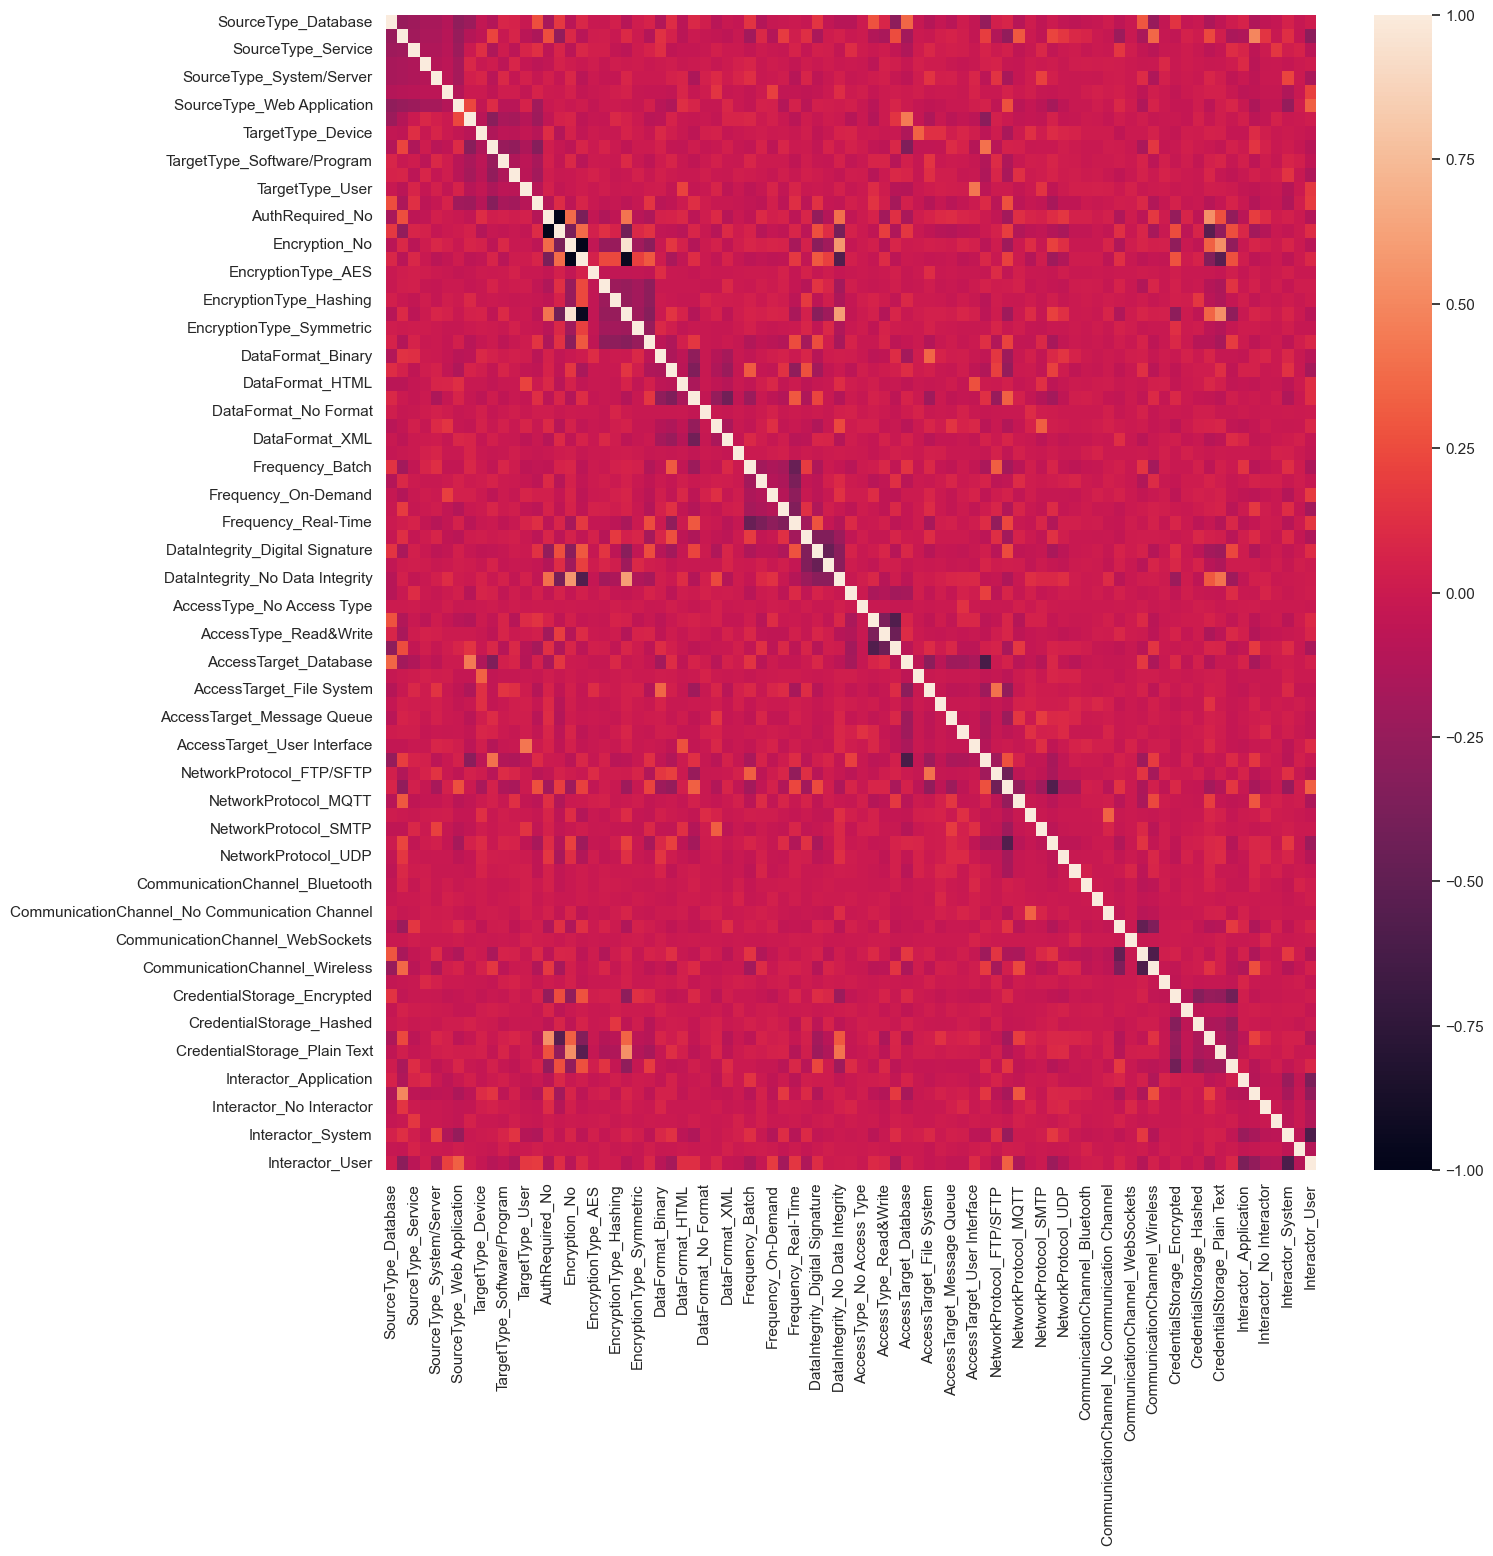

In [30]:
corrtable = pd.DataFrame(data=X_encoded_df).corr()
sns.set_theme(rc={'figure.figsize':(15,15)})
sns.heatmap(corrtable)

# Machine Learning

### Original Split

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Display the preprocessed data
print("Encoded Features:\n", X_encoded_df)
print("Encoded Target:\n", y_encoded)
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Encoded Features:
       SourceType_Database  SourceType_Hardware  SourceType_Service  \
0                     1.0                  0.0                 0.0   
1                     0.0                  0.0                 0.0   
2                     0.0                  0.0                 0.0   
3                     0.0                  0.0                 0.0   
4                     1.0                  0.0                 0.0   
...                   ...                  ...                 ...   
4502                  0.0                  0.0                 0.0   
4503                  0.0                  1.0                 0.0   
4504                  0.0                  0.0                 0.0   
4505                  0.0                  0.0                 1.0   
4506                  0.0                  0.0                 0.0   

      SourceType_Software  SourceType_System  SourceType_User  \
0                     0.0                0.0              0.0   
1         

### Reduced data split

In [21]:
# Select top features
top_features_chi2 = chi2_results['Feature'].tolist()
top_features_mutual_info = mutual_info_df['Feature'].tolist()

# Combine the top features from both methods and remove duplicates
top_features = list(set(top_features_chi2 + top_features_mutual_info))

# Subset the data to include only the top features
X_top_features = X_encoded_df[top_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

NameError: name 'chi2_results' is not defined

In [33]:
X_top_features

,TargetType_Database,CommunicationChannel_NFC,NetworkProtocol_SMTP,Frequency_Batch,Frequency_Event-Driven,NetworkProtocol_FTP/SFTP,Interactor_No Interactor,NetworkProtocol_WebSockets,CommunicationChannel_Bluetooth,AccessType_No Access Type,...,AccessTarget_Web Service/API,NetworkProtocol_MQTT,SourceType_User,SourceType_Software/Program,AuthRequired_Yes,CredentialStorage_No Credential Storage,AccessTarget_Device,AccessTarget_User Interface,TargetType_Device,AuthRequired_No
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4504,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4505,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_encoded_df

,SourceType_Database,SourceType_Device,SourceType_Service,SourceType_Software/Program,SourceType_System/Server,SourceType_User,SourceType_Web Application,TargetType_Database,TargetType_Device,TargetType_Service,...,CredentialStorage_No Credential Storage,CredentialStorage_Plain Text,CredentialStorage_Secure Vault,Interactor_Application,Interactor_Device,Interactor_No Interactor,Interactor_Service,Interactor_System,Interactor_Third-Party API,Interactor_User
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4504,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4505,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Algorithms

### Gradient Boosting

In [67]:

# Define the XGBoost model
model = XGBClassifier(random_state=42)

# Create the pipeline
clf = Pipeline(steps=[('classifier', model)])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Decode the predictions back to original labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate the model
print("Best parameters found: ", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("Classification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

ValueError: 
All the 216 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\YOGA\anaconda3\Lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\YOGA\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8 9], got ['Credential Stuffing' 'Cross-Site Request Forgery (CSRF)'
 'Denial of Service (DoS)' 'Directory Traversal'
 'Distributed Denial of Service (DDoS)' 'Drive-by Download Attacks'
 'No Threat' 'Password Attack' 'Remote Code Execution (RCE)'
 'Side-Channel Attack']


### Decision Tree

In [68]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize and perform Grid Search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(report)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.4775561097256858
                                      precision    recall  f1-score   support

                 Credential Stuffing       0.50      0.45      0.47        80
   Cross-Site Request Forgery (CSRF)       0.46      0.45      0.46        80
             Denial of Service (DoS)       0.71      0.68      0.69        80
                 Directory Traversal       0.50      0.51      0.50        81
Distributed Denial of Service (DDoS)       0.47      0.57      0.52        80
           Drive-by Download Attacks       0.42      0.41      0.42        80
                           No Threat       0.43      0.47      0.45        81
                     Password Attack       0.48      0.44      0.46        80
         Remote Code Execution (RCE)       0.37      0.35      0.36        80
                 Si

### Random Forest

In [69]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
                                      precision    recall  f1-score   support

                 Credential Stuffing       0.73      0.71      0.72        80
   Cross-Site Request Forgery (CSRF)       0.61      0.64      0.63        80
             Denial of Service (DoS)       0.86      0.84      0.85        80
                 Directory Traversal       0.76      0.72      0.74        81
Distributed Denial of Service (DDoS)       0.71      0.75      0.73        80
           Drive-by Download Attacks       0.68      0.74      0.71        80
                           No Threat       0.58      0.54      0.56        81
                     Password Attack       0.75      0.74      0.74        80
         Remote Code Execution (RCE)       0.71      0.69      0.70        80
                 Side-Channel Attack       0.66      0.69      0.67        80

                            accuracy                           0.70       802
                           macro avg  

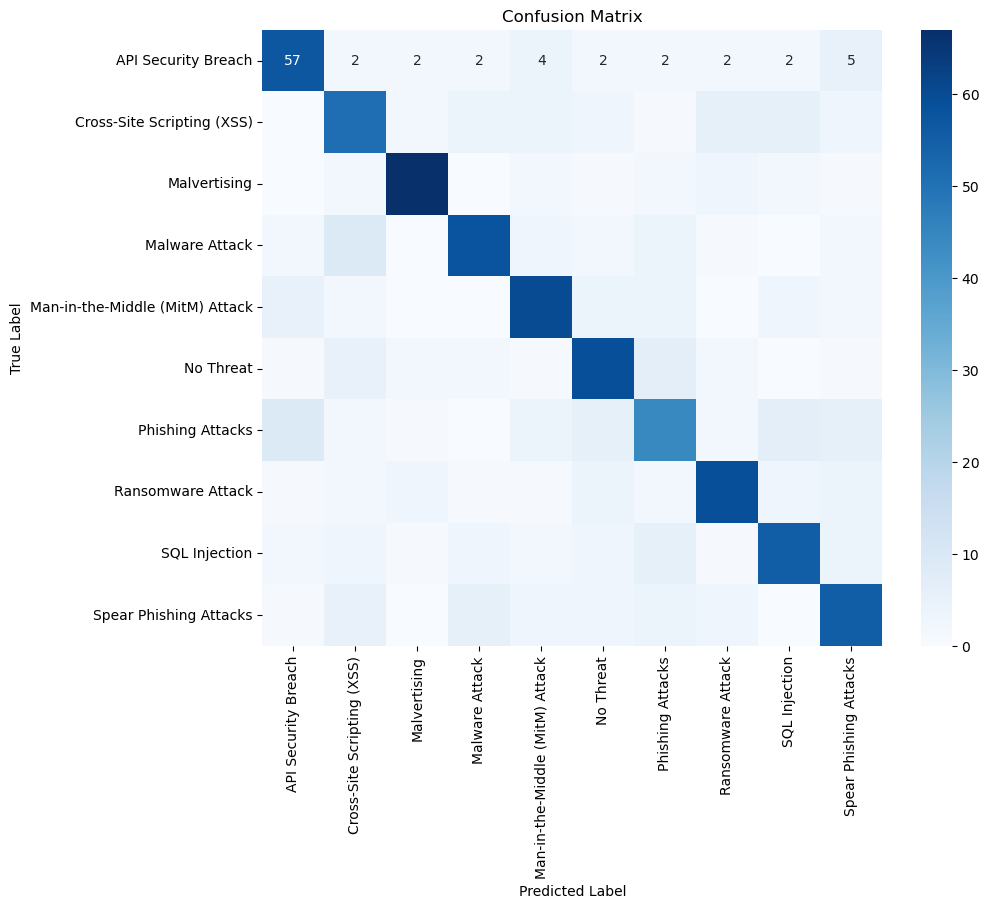

In [70]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage with your data
# Assuming y_test contains the true labels and y_pred_best contains the predicted labels
classes = label_encoder.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

## More advanced models

In [71]:
param_grid_rf = {
    'n_estimators': [200, 400, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

In [72]:
# Initialize the Randomized Search
randomized_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid_rf, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the randomized search to the data
randomized_search.fit(X_train, y_train)

# Best parameters from randomized search
print("Best Parameters from Randomized Search:")
print(randomized_search.best_params_)

# Predict with the best estimator
best_clf_randomized = randomized_search.best_estimator_
y_pred_best_randomized = best_clf_randomized.predict(X_test)

# Evaluate the tuned model
print("\nConfusion Matrix (Tuned Model - Randomized Search):")
plot_confusion_matrix(y_test, y_pred_best_randomized, classes=classes, title='Randomized Search Confusion Matrix')
print(classification_report(y_test, y_pred_best_randomized, target_names=classes))
print("\nAccuracy Score (Tuned Model - Randomized Search):")
print(accuracy_score(y_test, y_pred_best_randomized))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier on the balanced data
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred_smote = clf_smote.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix (SMOTE):")
plot_confusion_matrix(y_test, y_pred_smote, classes=classes, title='SMOTE Confusion Matrix')
print(classification_report(y_test, y_pred_smote, target_names=classes))
print("\nAccuracy Score (SMOTE):")
print(accuracy_score(y_test, y_pred_smote))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Accuracy: {accuracy_score(y_test, y_pred)}")
    plot_confusion_matrix(y_test, y_pred, classes=classes, title=f'{model_name} Confusion Matrix')
    print(classification_report(y_test, y_pred, target_names=classes))


In [74]:
# Additional Feature Engineering Steps
# You can create interaction terms, polynomial features, or domain-specific features

# Example: Adding interaction terms (this is just an example; adjust according to your data)
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_encoded_df)

# Convert back to DataFrame for better readability (optional)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_encoded_df.columns))


In [75]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform cross-validation
scores = cross_val_score(xgb_clf, X_poly_df, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {scores.mean()}")

# Train and evaluate XGBoost model
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the XGBoost model
print("\nConfusion Matrix (XGBoost):")
plot_confusion_matrix(y_test, y_pred_xgb, classes=classes, title='XGBoost Confusion Matrix')
print(classification_report(y_test, y_pred_xgb, target_names=classes))
print("\nAccuracy Score (XGBoost):")
print(accuracy_score(y_test, y_pred_xgb))


C:\Users\YOGA\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\YOGA\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


KeyboardInterrupt: 

In [76]:
from sklearn.model_selection import StratifiedKFold

# Initialize Random Forest with best parameters found
best_rf_clf = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=6, criterion='gini', random_state=42)

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_rf_clf, X_poly_df, y_encoded, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean()}")

# Train and evaluate Random Forest model with cross-validation
best_rf_clf.fit(X_train, y_train)
y_pred_rf_cv = best_rf_clf.predict(X_test)

# Evaluate the Random Forest model with cross-validation
print("\nConfusion Matrix (Random Forest with Cross-Validation):")
plot_confusion_matrix(y_test, y_pred_rf_cv, classes=classes, title='Random Forest (CV) Confusion Matrix')
print(classification_report(y_test, y_pred_rf_cv, target_names=classes))
print("\nAccuracy Score (Random Forest with Cross-Validation):")
print(accuracy_score(y_test, y_pred_rf_cv))


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_rf_clf, X_poly_df, y_encoded, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

param_range = [100, 200, 300, 400, 500]
train_scores, test_scores = validation_curve(best_rf_clf, X_poly_df, y_encoded, param_name='n_estimators', param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(param_range, train_scores_mean, label='Training Score')
plt.plot(param_range, test_scores_mean, label='Cross-Validation Score')
plt.title('Validation Curve for Random Forest (n_estimators)')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()


In [ ]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_encoded_df)

# Convert back to DataFrame for better readability
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_encoded_df.columns))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a Random Forest Classifier
best_rf_clf = RandomForestClassifier(random_state=42)
best_rf_clf.fit(X_train, y_train)

# Extract feature importances
feature_importances = best_rf_clf.feature_importances_
features = poly.get_feature_names_out(X_encoded_df.columns)  # Get feature names from polynomial transformation

# Ensure the lengths match
assert len(features) == len(feature_importances), "The number of features does not match the number of importances."

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

In [ ]:

# Adding regularization using max_depth and min_samples_split
clf_reg = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf_reg.fit(X_train, y_train)
y_pred_reg = clf_reg.predict(X_test)

# Evaluate the regularized model
print("\nConfusion Matrix (Regularized Model):")
plot_confusion_matrix(y_test, y_pred_reg, classes=label_encoder.classes_, title='Regularized Model Confusion Matrix')
print(classification_report(y_test, y_pred_reg, target_names=label_encoder.classes_))
print("\nAccuracy Score (Regularized Model):")
print(accuracy_score(y_test, y_pred_reg))


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Select features based on importance
selector = SelectFromModel(best_rf_clf, threshold='median', prefit=True)
X_selected = selector.transform(X_poly_df)

# Split the selected features data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Retrain and evaluate the model with selected features
clf_sel = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = clf_sel.predict(X_test_sel)

print("\nConfusion Matrix (Feature Selection):")
plot_confusion_matrix(y_test_sel, y_pred_sel, classes=label_encoder.classes_, title='Feature Selection Confusion Matrix')
print(classification_report(y_test_sel, y_pred_sel, target_names=label_encoder.classes_))
print("\nAccuracy Score (Feature Selection):")
print(accuracy_score(y_test_sel, y_pred_sel))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Initialize models
clf1 = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf2 = LogisticRegression(max_iter=1000, random_state=42)
clf3 = SVC(kernel='linear', probability=True, random_state=42)

# Create an ensemble model
eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('lr', clf2), ('svc', clf3)], voting='soft')

# Train ensemble model
eclf.fit(X_train, y_train)
y_pred_ensemble = eclf.predict(X_test)

# Evaluate the ensemble model
print("\nConfusion Matrix (Ensemble Model):")
plot_confusion_matrix(y_test, y_pred_ensemble, classes=label_encoder.classes_, title='Ensemble Model Confusion Matrix')
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))
print("\nAccuracy Score (Ensemble Model):")
print(accuracy_score(y_test, y_pred_ensemble))


In [ ]:
from sklearn.dummy import DummyClassifier
# Train a Dummy Classifier as a baseline
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluate the Dummy Classifier
print("Dummy Classifier Performance:")
print("\nConfusion Matrix (Dummy Classifier):")
plot_confusion_matrix(y_test, y_pred_dummy, classes=label_encoder.classes_, title='Dummy Classifier Confusion Matrix')
print(classification_report(y_test, y_pred_dummy, target_names=label_encoder.classes_))
print("\nAccuracy Score (Dummy Classifier):")
print(accuracy_score(y_test, y_pred_dummy))

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_clf.fit(X_train, y_train)
y_pred_log_reg = log_reg_clf.predict(X_test)

# Evaluate the Logistic Regression model
print("\nConfusion Matrix (Logistic Regression):")
plot_confusion_matrix(y_test, y_pred_log_reg, classes=label_encoder.classes_, title='Logistic Regression Confusion Matrix')
print(classification_report(y_test, y_pred_log_reg, target_names=label_encoder.classes_))
print("\nAccuracy Score (Logistic Regression):")
print(accuracy_score(y_test, y_pred_log_reg))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assume X and y are your features and target
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(), X_encoded_df, y_encoded, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [50]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# Assuming your trained model is stored in grid_search
# and you have the training data stored in X_train_res and y_train_res

# Predict on the training set
y_train_pred = grid_search.predict(X_train)

# Decode the predictions and the true labels back to original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)

# Evaluate the model on the training set
print("Performance on the training set:")
print("Accuracy:", accuracy_score(y_train_decoded, y_train_pred_decoded))
print("Classification Report:\n", classification_report(y_train_decoded, y_train_pred_decoded))

# Additional metrics can be added here if needed


In [ ]:
import pickle

# Create the pipeline with the preprocessor and the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X, y_encoded)

# Save the model and preprocessor to a pickle file
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(grid_search, file)


# For Neural Networks, OneHot Encoding the target variable is important.

In [60]:
source = data #options: data, data_reduced, filtered_data

In [61]:
# Encode the categorical features using OneHotEncoder
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(source.drop('Threat', axis=1))

# Convert the encoded features to a DataFrame for better readability (optional)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(source.drop('Threat', axis=1).columns))

# One-hot encode the target variable
onehot_encoder_target = OneHotEncoder(sparse_output=False)  # Set sparse=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(source[['Threat']])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, source['Threat'])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\YOGA\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0597 - loss: 3.0955 - val_accuracy: 0.0798 - val_loss: 2.9941
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0794 - loss: 2.9882 - val_accuracy: 0.0892 - val_loss: 2.9433
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0989 - loss: 2.9354 - val_accuracy: 0.1150 - val_loss: 2.8980
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1102 - loss: 2.8931 - val_accuracy: 0.1185 - val_loss: 2.8747
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1307 - loss: 2.8563 - val_accuracy: 0.1115 - val_loss: 2.8354
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1380 - loss: 2.8173 - val_accuracy: 0.1291 - val_loss: 2.8163
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1495 - loss: 2.7823 - val_accuracy: 0.1350 - val_loss: 2.7888
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1491 - loss: 2.7622 - val_accu

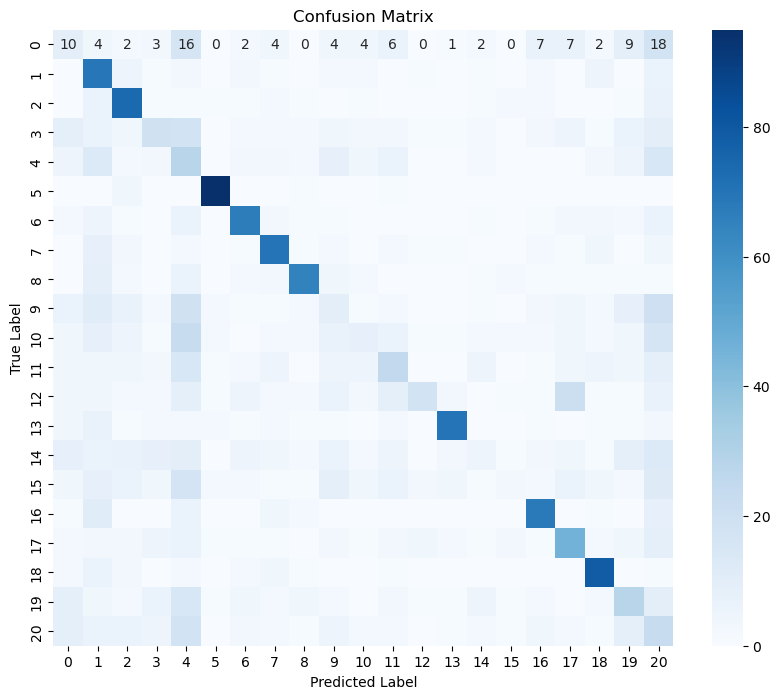

In [62]:

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the training and testing labels
y_train_encoded = onehot_encoder_target.transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder_target.transform(y_test.values.reshape(-1, 1))

# Define the DNN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [63]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
                                      precision    recall  f1-score   support

                 API Security Breach       0.16      0.20      0.18       101
                 Credential Stuffing       0.66      0.66      0.66       101
   Cross-Site Request Forgery (CSRF)       0.65      0.69      0.67       101
          Cross-Site Scripting (XSS)       0.21      0.23      0.22       101
                       Cryptojacking       0.29      0.23      0.25       102
             Denial of Service (DoS)       0.78      0.92      0.85       101
                 Directory Traversal       0.68      0.74      0.70       102
Distributed Denial of Service (DDoS)       0.73      0.75      0.74       102
           Drive-by Download Attacks       0.67      0.67      0.67       101
                        Malvertising       0.19      0.18      0.18       102
                      Malware Attack       0.18      0.15      0.16       102
     Man-in-the-Middle (MitM) Attack   

### Throw out worst classes

In [64]:
low_accuracy_classes = [
    'API Security Breach', 'Cross-Site Scripting (XSS)', 'Cryptojacking', 
    'Malvertising', 'Malware Attack', 'Man-in-the-Middle (MitM) Attack', 
    'Phishing Attacks', 'Ransomware Attack', 'Zero-day Exploit', 'SQL Injection', 'Spear Phishing Attacks'
]

# Drop the rows with low accuracy classes
top_data = data[~data['Threat'].isin(low_accuracy_classes)]

# Encode the categorical features using OneHotEncoder
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(top_data.drop('Threat', axis=1))

# Convert the encoded features to a DataFrame for better readability (optional)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(top_data.drop('Threat', axis=1).columns))

# One-hot encode the target variable
onehot_encoder_target = OneHotEncoder(sparse_output=False)  # Set sparse=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(top_data[['Threat']])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, top_data['Threat'])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train a new random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred, target_names=onehot_encoder_target.categories_[0])
print(report)

                                      precision    recall  f1-score   support

                 Credential Stuffing       0.73      0.71      0.72        80
   Cross-Site Request Forgery (CSRF)       0.61      0.64      0.63        80
             Denial of Service (DoS)       0.86      0.84      0.85        80
                 Directory Traversal       0.76      0.72      0.74        81
Distributed Denial of Service (DDoS)       0.71      0.75      0.73        80
           Drive-by Download Attacks       0.68      0.74      0.71        80
                           No Threat       0.58      0.54      0.56        81
                     Password Attack       0.75      0.74      0.74        80
         Remote Code Execution (RCE)       0.71      0.69      0.70        80
                 Side-Channel Attack       0.66      0.69      0.67        80

                            accuracy                           0.70       802
                           macro avg       0.71      0.70     

In [79]:
import pickle
# Save the model and preprocessor to a pickle file
with open('RF_algorithm.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

Epoch 1/100


C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\YOGA\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\YOGA\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1140 - loss: 2.4038 - val_accuracy: 0.1791 - val_loss: 2.2727
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1328 - loss: 2.2873 - val_accuracy: 0.2181 - val_loss: 2.2248
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1763 - loss: 2.2489 - val_accuracy: 0.2352 - val_loss: 2.1633
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1887 - loss: 2.2088 - val_accuracy: 0.2508 - val_loss: 2.1056
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2156 - loss: 2.1659 - val_accuracy: 0.2601 - val_loss: 2.0842
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2026 - loss: 2.1642 - val_accuracy: 0.3100 - val_loss: 2.0413
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2511 - loss: 2.0816 - val_accuracy: 0.3287 - val_loss: 1.9911
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2628 - loss: 2.0513 - val_accuracy: 0.3349 - val_loss: 1.

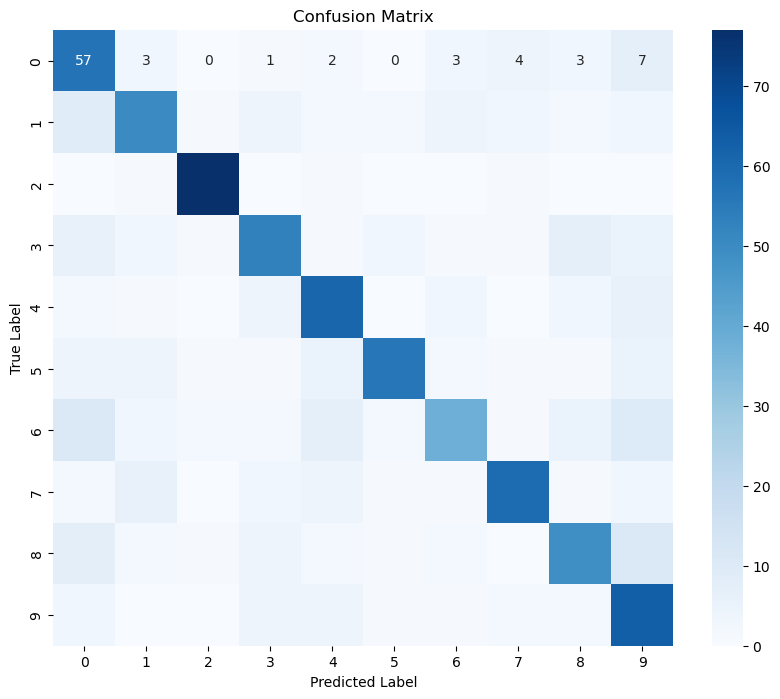

In [65]:

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the training and testing labels
y_train_encoded = onehot_encoder_target.transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder_target.transform(y_test.values.reshape(-1, 1))

# Define the DNN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [77]:
X_encoded_df

,SourceType_Database,SourceType_Device,SourceType_Service,SourceType_Software/Program,SourceType_System/Server,SourceType_User,SourceType_Web Application,TargetType_Database,TargetType_Device,TargetType_Service,...,CredentialStorage_No Credential Storage,CredentialStorage_Plain Text,CredentialStorage_Secure Vault,Interactor_Application,Interactor_Device,Interactor_No Interactor,Interactor_Service,Interactor_System,Interactor_Third-Party API,Interactor_User
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1962,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.0665 - loss: 20.3274 - val_accuracy: 0.2148 - val_loss: 17.3993 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.1456 - loss: 17.5457 - val_accuracy: 0.2952 - val_loss: 15.5266 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.3021 - loss: 14.8192 - val_accuracy: 0.4120 - val_loss: 12.6282 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4374 - loss: 11.8407 - val_accuracy: 0.4660 - val_loss: 10.3904 - learning_rate: 0.0010
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5566 - loss: 9.6145 - val_accuracy: 0.4836 - val_loss: 9.4767 - learning_rate: 0.0010
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.6362 - loss: 8.6852 - val_accuracy: 0.5135 - val_loss: 9.3367 - learning_rate: 0.0010
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accur

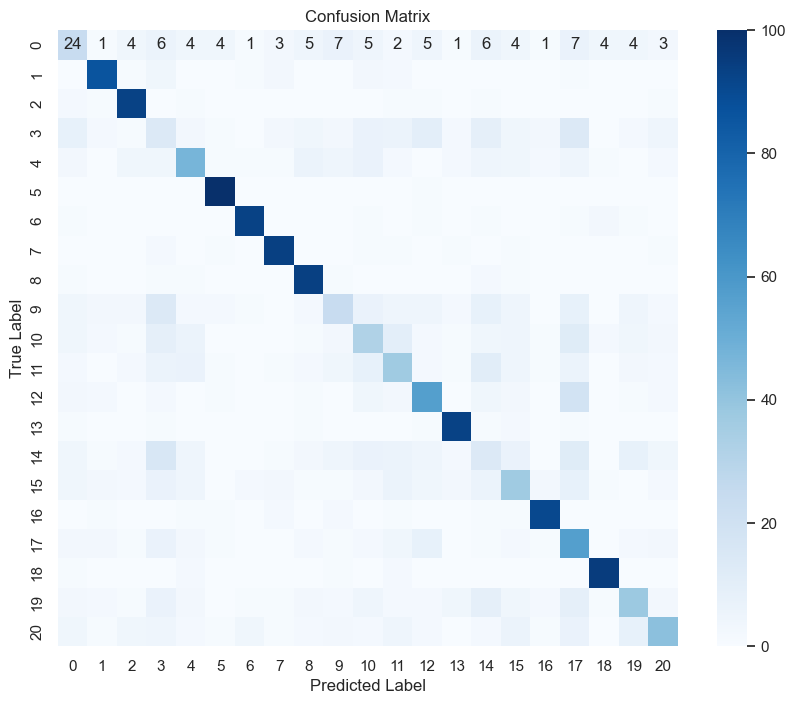

In [101]:
# Define the DNN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

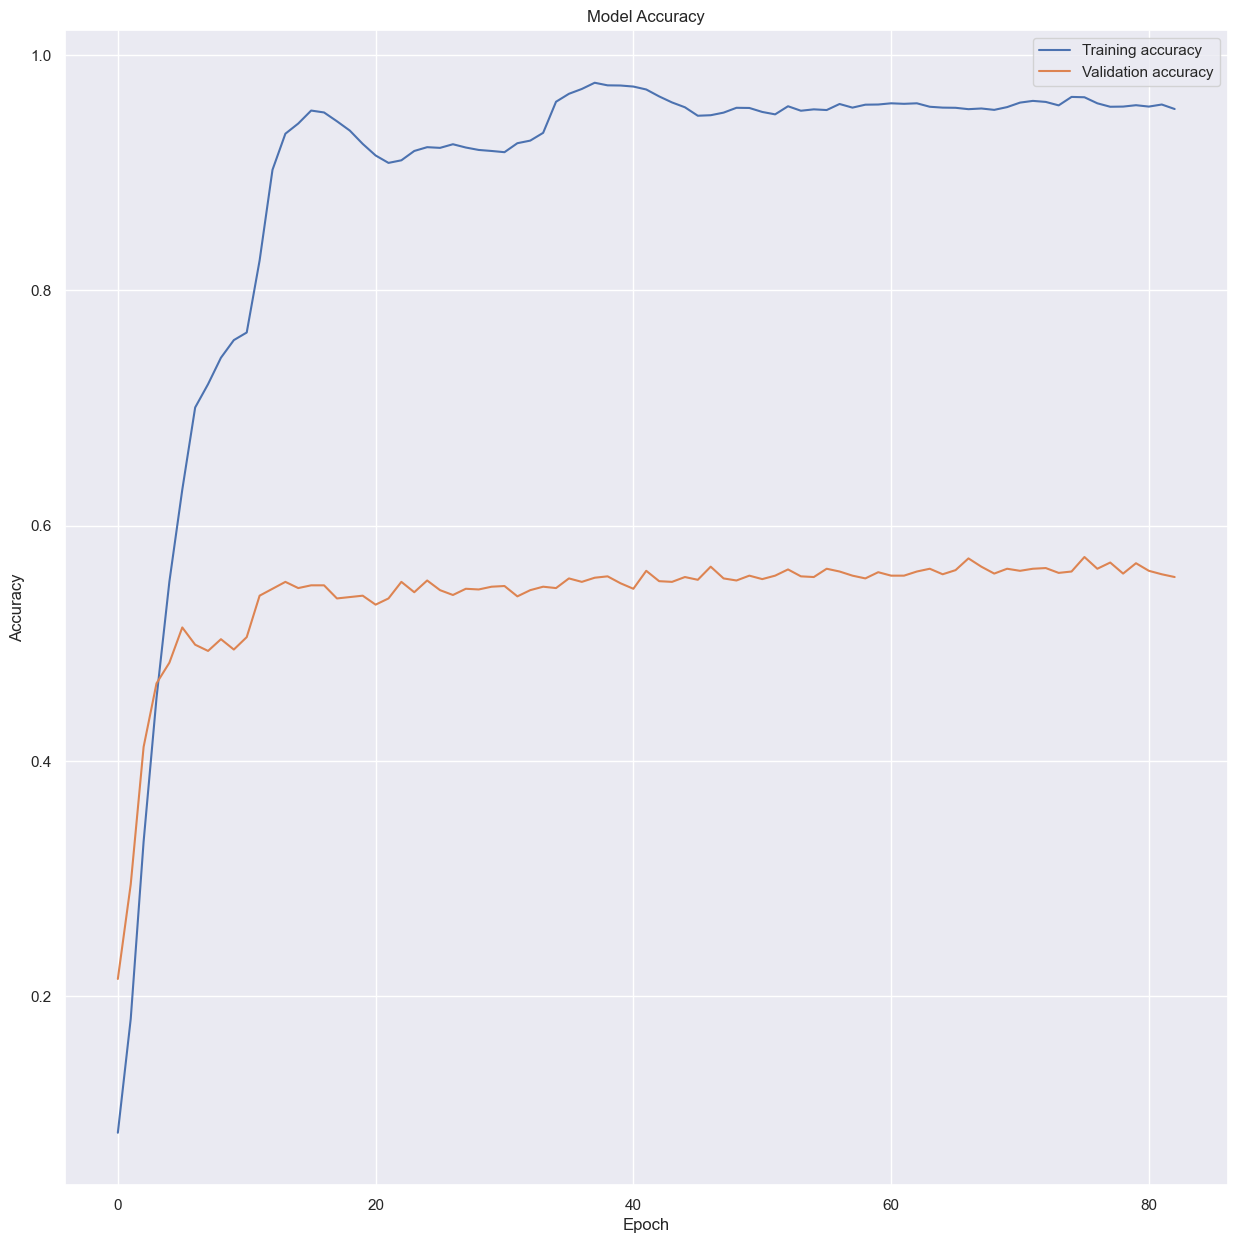

In [106]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [112]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

C:\Users\Dennis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0502 - loss: 17.4307 - val_accuracy: 0.0534 - val_loss: 12.3199 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0599 - loss: 13.2475 - val_accuracy: 0.0904 - val_loss: 11.1195 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0689 - loss: 12.1100 - val_accuracy: 0.1121 - val_loss: 10.6999 - learning_rate: 1.0000e-04
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0776 - loss: 11.6302 - val_accuracy: 0.1303 - val_loss: 10.4619 - learning_rate: 1.0000e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0844 - loss: 11.2719 - val_accuracy: 0.1496 - val_loss: 10.2693 - learning_rate: 1.0000e-04
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1033 - loss: 10.9838 - val_accuracy: 0.1684 - val_loss: 10.0979 - learning_rate: 1.0000e-04
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━

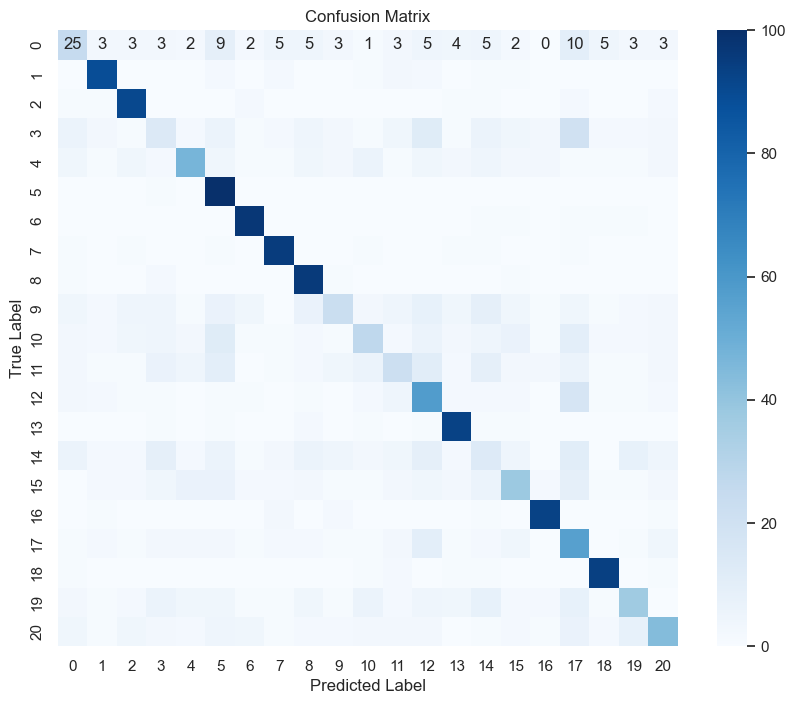

In [113]:
# Define the DNN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased dropout rate
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased dropout rate
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased dropout rate
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()